이번 절에서는 캐글에서는 제공하는 타이타닉 탑승자 데이터를 기반으로 생존자 예측을 사이킷런으로 수행해보자.
1장에서 판다스의 DataFrame을 설명할 때 바로 이 타이타닉 탑승자 데이터를 이용했다. 1장의 판다스 설명 부분을
건너뛴 분들은 https://www.kaggle.com/c/titanic/data 에 접속해 데이터를 내려받기 바랍니다. 저장시 train.csv를 새로운 주피터 노트북이 위치한 디렉토리에 'titanic_train.csv'라는 이름으로 저장하면 된다.

내려받은 타이타닉 탑승자 데이터에 대해 개략적으로 살펴보자. 

* Passengerid: 탑승자 데이터 일련번호
* survived: 생존 여부, 0 = 사망, 1= 생존 :: y값이 될 녀석!!! == target 변수
* pclass: 티켓의 선실 등급, 1=일등석, 2=이등석, 3=삼등석
* sex: 탑승자 성별
* name: 탑승자 이름
* Age: 탑승자 나이
* sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
* parch: 같이 탑승한 부모님 또는 어린이 인원수
* ticket: 티켓 번호
* fare: 요금
* cabin: 선실 번호
* embarked: 중간 정착 항구 C=Cherbourg, Q=Queenstown, S=Southampton 

In [1]:
# 데이터의 정보와 EDA를 위한 라이브러리 호출!!!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 로드
titan_df = pd.read_csv('D:/pythonTest/train.csv')
titan_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
print('\n### 학습 데이터 정보 ###\n')
print(titan_df.info())


### 학습 데이터 정보 ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [4]:
# 결측값을 확인해보자.
titan_df.isnull().sum().sum()

866

In [5]:
# missing value를 처리
titan_df['Age'] = titan_df.Age.fillna(np.mean(titan_df.Age))
titan_df['Cabin'] = titan_df.Cabin.fillna('N')
titan_df['Embarked'] = titan_df.Embarked.fillna('N')
print('데이터셋의 null값:', titan_df.isnull().sum().sum())

데이터셋의 null값: 0


문자열 중에서 Sex, Cabin, Embarked의 분포 혹은 분류를 살펴보자. 

In [6]:
print('Sex 값 분포:\n', titan_df.Sex.value_counts())
print('Cabin 값 분포:\n', titan_df.Cabin.value_counts())
print('Embarked 값 분포:\n', titan_df.Embarked.value_counts())

Sex 값 분포:
 male      577
female    314
Name: Sex, dtype: int64
Cabin 값 분포:
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64
Embarked 값 분포:
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [7]:
titan_df['Cabin']=titan_df.Cabin.str[0]
print(titan_df.Cabin.value_counts())

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64


In [8]:
# 성별에 따른 생존확률을 분석해봅시다.

titan_df.groupby(by=['Sex','Survived'])['Survived'].count()
# s_rate_f = 233/(233+81)
# print(s_rate_f) # 여성의 생존률
s_rate_m = 109/(468+109)
print(s_rate_m) # 남성의 생존률

0.18890814558058924


<AxesSubplot:xlabel='Sex', ylabel='Survived'>

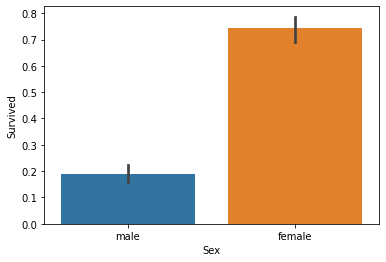

In [9]:
sns.barplot(x='Sex',y='Survived', data=titan_df)

부자와 가난한 사람 간의 생존확률은 어떨까? 부를 측정할 수 있는 속성으로 적당한 것은 객실 등급일 것이다. 일등실, 이등실, 마지막으로 삼등실에 따라 생존 확률을 살펴보자. 단순히 객실 등급별 성별에 따른 생존 확률을 표현해보도록 하자. 앞의 barplot()함수에 x좌표에 'Pclass'를 , 그리고 hue 파라미터를 추가해서 hue='Sex'와 같이 입력하면 간단하게 할 수 있다.  

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

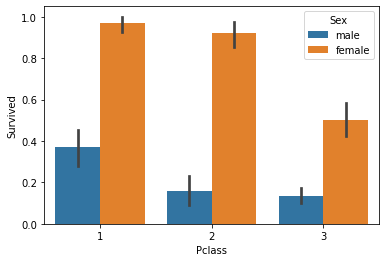

In [10]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titan_df)

여성의 경우 일, 이등실에 따른 생존 확률의 차이는 크지 않으나, 삼등실의 경우 생존 확률이 상대적으로 많이 떨어짐을 알 수 있다. 남성의 경우는 일등실의 생존 확률이 이, 삼등실의 생존 확률보다 월등히 높다. 이번에는 Age에 따른 생존 확률을 알아보겠습니다. Age의 경우 값 종류가 많기 때문에 범위별로 분류해 카테고리 값을 할당하자.

    0~5세는 baby
    6~12세는 child
    13~18세는 teen
    19~25세는 student
    26~35세는 young Adult
    36~60세는 adult
    61세 이상은 elderly

-1이하의 오류 값은 Unknown으로 분류 

In [11]:
def get_category(age):
    capital = ''
    if age <=-1: capital='unknown'
    elif age<=5: capital='baby'
    elif age<=12: capital='child'
    elif age<=18: capital= 'teen'
    elif age<=25: capital='student'
    elif age<=35: capital='y_adult'
    elif age<=60: capital='adult'        
    else: capital = 'elderly'
    return capital

<AxesSubplot:xlabel='Age_cat', ylabel='Survived'>

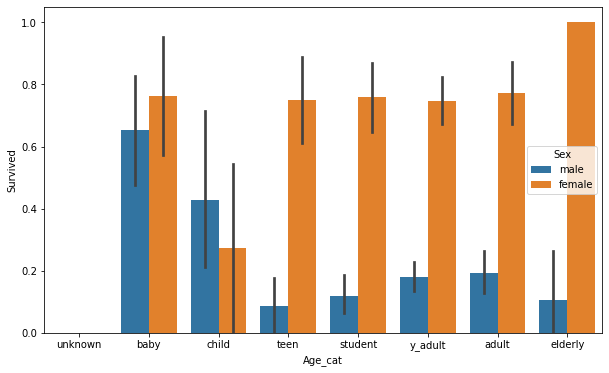

In [12]:
# 막대그래프의 크기 :: figure를 더 크게 설정
plt.figure(figsize=(10,6))

# X축의 값을 정렬하기 위한 list를 생성
group_names = ['unknown','baby','child','teen','student','y_adult','adult','elderly']

# get_category(x)는 입력값으로 'Age'의 value들을 받아서 Capital로 반환
titan_df['Age_cat'] = titan_df['Age'].apply(lambda x: get_category(x)) # 파생변수
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titan_df, order=group_names)

 여성_baby와 elderly의 경우 비교적 생존확률이 높았다. 이제까지의 분석을 보면 Sex,Age,Pclass 등이 주요 피처(feature)임을 깨달았다.

In [13]:
titan_df.info() #데이터 정보를 보는 code문
titan_df.select_dtypes(include='object').columns # 컬럼들만 가지고 오는 code문

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  Age_cat      891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age_cat'], dtype='object')

In [14]:
# 결측값 처리 함수
def fillna(data_df):
    data_df['Age'].fillna(np.mean(data_df['Age']),inplace=True)
    data_df['Cabin'].fillna('N',inplace=True)
    data_df['Embarked'].fillna('N',inplace=True)    
    return data_df

In [15]:
# 머신러닝 알고리즘에 불필요 속성(attr:: col)제거
# 'Ticket', 'Name', 'PassengerId', 'Cabin', 'Embarked' 컬럼들 삭제
def drop_ftr(data_df):
    data_df.drop(['Ticket', 'Name', 'PassengerId', 'Cabin', 'Embarked'], axis=1, inplace=True)
    return data_df

In [16]:
# 레이블 인코딩 수행
from sklearn.preprocessing import LabelEncoder

def le_encode_ftrs(data_df):    
    features = ['Sex']
    for ftr in features:
        le=LabelEncoder() # 위의 LabelEncoder를 객체화
        le=le.fit(data_df[ftr])
        data_df[ftr]=le.transform(data_df[ftr])       
    return data_df

In [17]:
# 위에서 설정한 함수들을 다 통합
def preprocessing_ftrs(data_df):
    data_df = fillna(data_df)
    data_df = drop_ftr(data_df)
    data_df = le_encode_ftrs(data_df)
    return data_df

In [18]:
# 원본 데이터 재로딩
titanic_df = pd.read_csv('/pythonTest/train.csv')
y_titanic = titanic_df['Survived']
X_titanic = titanic_df.drop('Survived', axis=1)

preprocessing_ftrs(X_titanic) # inplace = True 파라미터를 넣었으므로 원본 변형이 일어난다

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.000000,1,0,7.2500
1,1,0,38.000000,1,0,71.2833
2,3,0,26.000000,0,0,7.9250
3,1,0,35.000000,1,0,53.1000
4,3,1,35.000000,0,0,8.0500
...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000
887,1,0,19.000000,0,0,30.0000
888,3,0,29.699118,1,2,23.4500
889,1,1,26.000000,0,0,30.0000


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_titanic, y_titanic, test_size=.2,
                                                 random_state=11)

ML 알고리즘에서 의사결정나무, 랜덤포레스트, 로지스틱 회귀를 사용하여 학습기를 만들어보자. (로지스틱 회귀는 선형회귀에서 파생되었지만, 매우 강력한 분류알고리즘) 

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score as acc_sc

# 의사결정나무, 랜덤포레스트, 로지스틱 회귀 객체화
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(random_state=11)

#DecisionTreeClassifier 학습/예측평가
dt_clf.fit(X_train,y_train)
dt_pred = dt_clf.predict(X_val)
print('dt_clf의 정확도:{0:.4f}'.format(acc_sc(y_val,dt_pred)))

#RandomForestClassifier 학습/예측평가
rf_clf.fit(X_train,y_train)
rf_pred = rf_clf.predict(X_val)
print('rf_clf의 정확도:{0:.4f}'.format(acc_sc(y_val,rf_pred)))

#LogisticRegression 학습/예측평가
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_val)
print('lr_clf의 정확도:{0:.4f}'.format(acc_sc(y_val,lr_pred)))

dt_clf의 정확도:0.7933
rf_clf의 정확도:0.8603
lr_clf의 정확도:0.8436


이번에는 교차검증을 cross_val_score()를 통해서 수행해봅시다. 

In [21]:
for i,j in enumerate(['ysp','jh','yh','yj','sm','es']):
    print(i,j)

0 ysp
1 jh
2 yh
3 yj
4 sm
5 es


In [22]:
# decision_tree cv
from sklearn.model_selection import cross_val_score

score_dt = cross_val_score(dt_clf,X_titanic, y_titanic, cv=5)
for n_iter, accuracy in enumerate(score_dt):
    print('{0}번째 cv 정확도:{1:.4f}'.format(n_iter, accuracy))
    
print('평균 정확도:{0:.4f}'.format(np.mean(score_dt)))

0번째 cv 정확도:0.7151
1번째 cv 정확도:0.8034
2번째 cv 정확도:0.8034
3번째 cv 정확도:0.7472
4번째 cv 정확도:0.7921
평균 정확도:0.7722


In [23]:
# RandomForest cv
from sklearn.model_selection import cross_val_score

score_rf = cross_val_score(rf_clf,X_titanic, y_titanic, cv=5)
for n_iter, accuracy in enumerate(score_rf):
    print('{0}번째 cv 정확도:{1:.4f}'.format(n_iter, accuracy))
    
print('평균 정확도:{0:.4f}'.format(np.mean(score_rf)))

0번째 cv 정확도:0.7709
1번째 cv 정확도:0.8090
2번째 cv 정확도:0.8539
3번째 cv 정확도:0.7753
4번째 cv 정확도:0.8483
평균 정확도:0.8115


In [24]:
# LogisticRegression cv
from sklearn.model_selection import cross_val_score

score_lr = cross_val_score(lr_clf,X_titanic, y_titanic, cv=5)
for n_iter, accuracy in enumerate(score_lr):
    print('{0}번째 cv 정확도:{1:.4f}'.format(n_iter, accuracy))
    
print('평균 정확도:{0:.4f}'.format(np.mean(score_lr)))

0번째 cv 정확도:0.7877
1번째 cv 정확도:0.7753
2번째 cv 정확도:0.7809
3번째 cv 정확도:0.7640
4번째 cv 정확도:0.8146
평균 정확도:0.7845


In [26]:
# 최종 테스트 제출
X_titanic # train에서 전체 X
y_titanic # train에서 전체 y

X_titan_test = pd.read_csv('/pythonTest/test.csv') # 전체 데이터에서의 test

In [27]:
preprocessing_ftrs(X_titan_test)

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,34.50000,0,0,7.8292
1,3,0,47.00000,1,0,7.0000
2,2,1,62.00000,0,0,9.6875
3,3,1,27.00000,0,0,8.6625
4,3,0,22.00000,1,1,12.2875
...,...,...,...,...,...,...
413,3,1,30.27259,0,0,8.0500
414,1,0,39.00000,0,0,108.9000
415,3,1,38.50000,0,0,7.2500
416,3,1,30.27259,0,0,8.0500


In [28]:
X_titan_test.isna().sum()
# 마지막 fare의 결측값 대체하기

X_titan_test.Fare.fillna(np.mean(X_titan_test.Fare),inplace=True)

In [29]:
## 전체의 데이터로 학습
rf_clf.fit(X_titanic,y_titanic)
pred_final_rf = rf_clf.predict(X_titan_test)
print(pred_final_rf)

[0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 0 0 0]


In [32]:
result_df = pd.DataFrame(pred_final_rf.reshape(-1,1))
result_df1 = result_df.rename(columns={0:'Survived'})
result_df1.to_csv('D:/pythonTest/first_titan.csv')

In [31]:
gender_df = pd.read_csv('D:/pythonTest/gender_submission.csv')
actual_y = gender_df.Survived
acc_sc(actual_y,pred_final_rf)

0.8038277511961722